In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Лабораторная работа №2, часть 3

In [3]:
import math
from itertools import islice
from operator import attrgetter
from typing import Callable, Generator, NamedTuple

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from more_itertools import last
from nptyping import Array
from scipy.io import loadmat

from common import gradient_descent_regularized

## Загрузка данных

In [4]:
DATA = loadmat("ex2data3.mat")

X = DATA["X"]
print(f"Matrix X shape: {X.shape}")

IMG_SIZE = 20
IMG_RESOLUTION = (IMG_SIZE, IMG_SIZE)
IMG_VECTOR_LENGTH = IMG_SIZE * IMG_SIZE

PixelType = X.dtype.type
ImgVector = Array[PixelType, IMG_VECTOR_LENGTH]
ImgMatrix = Array[PixelType, IMG_SIZE, IMG_SIZE]

Y = DATA["y"]
print(f"Matrix Y shape: {Y.shape}")

OutputType = Y.dtype.type
OutputVector = Array[OutputType, ...]

FEATURES = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
TARGETS = np.reshape(Y, (Y.shape[0],))


Matrix X shape: (5000, 400)
Matrix Y shape: (5000, 1)


### Изображения из набора данных

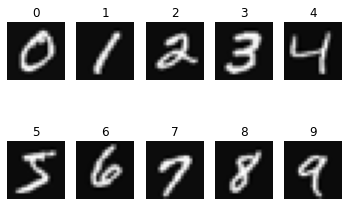

In [5]:
def display_image(ax: Axes, image: ImgVector):
    ax.imshow(np.reshape(image, IMG_RESOLUTION).T, cmap="gray")


class DigitIndex(NamedTuple):
    value: int
    index: int


def get_digit_indices(digit_values: OutputVector) -> Generator[DigitIndex, None, None]:
    digits = set(range(1, 11))
    for index, value in enumerate(digit_values):
        value = value[0]
        if value in digits:
            digits.remove(value)
            yield DigitIndex(int(value) % 10, index)

            if not digits:
                break


value_getter: Callable[[DigitIndex], int] = attrgetter("value")
digit_indices = sorted(get_digit_indices(Y), key=value_getter)

images_per_row = 5
row_count = math.ceil(len(digit_indices) / images_per_row)

img_fig, img_axes = plt.subplots(row_count, images_per_row)

for plot_index, digit_index in enumerate(digit_indices):
    ax = (img_axes[plot_index // images_per_row] if row_count > 1 else img_axes)[
        plot_index % images_per_row
    ]
    display_image(ax, X[digit_index.index])
    ax.set_title(str(digit_index.value))
    ax.axis("off")


### Бинарная классификация

In [6]:
def binary_classification_for_digit(digit: OutputType, y: OutputVector) -> OutputVector:
    return (y == digit).astype(OutputType)


### Оценка полученных результатов

In [7]:
def get_score(targets: OutputVector, predictions: OutputVector) -> float:
    assert targets.shape == predictions.shape

    return np.sum(targets == predictions) / targets.shape[0]


### Оценка полученных результатов

In [8]:
LEARNING_RATE = PixelType("1")
REG_PARAM = PixelType("0.01")
ITERATIONS_PER_DIGIT = 10000

binary_classifications = np.array(
    [
        FEATURES @ last(
            islice(gradient_descent_regularized(
                LEARNING_RATE,
                REG_PARAM,
                theta=np.zeros(IMG_VECTOR_LENGTH + 1),
                x=FEATURES,
                y=binary_classification_for_digit(digit, TARGETS),
                precision=PixelType("1e-6"),
            ), ITERATIONS_PER_DIGIT)
        )
        for digit in range(1, 11)
    ]
)
predictions = np.argmax(binary_classifications, axis=0) + 1
print(f"score = {get_score(TARGETS, predictions):.1%}")

score = 95.3%
